In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import geopandas as gp
import numpy as np
from matplotlib import pyplot as plt, colormaps, colors
import seaborn as sns
from exposure_matrices import load_data, image_path

root_path = Path().resolve().parents[1]
enrollment_2022_path = root_path / "data" / "enrollment_2022"
map_path = root_path / "data" / "NYS_Civil_Boundaries"
image_path = root_path / "images"

In [3]:
counties = gp.read_file(map_path / "Counties.shp")
counties["NAME"] = counties["NAME"].str.upper()
counties["NAME"] = counties["NAME"].apply(lambda x: x if x != "ST LAWRENCE" else "SAINT LAWRENCE")
data = load_data(2022)

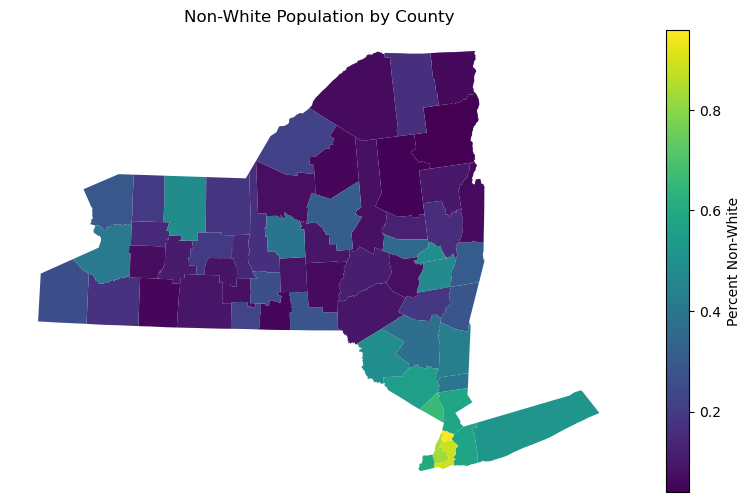

In [20]:
agg_white = data[["NUM_BLACK", "NUM_WHITE", "NUM_HISP", "K12", "COUNTY_NAME"]].groupby("COUNTY_NAME").sum()

agg_white["PER_WHITE"] = agg_white["NUM_WHITE"] / agg_white["K12"]
agg_white["PER_BLACK"] = agg_white["NUM_BLACK"] / agg_white["K12"]
agg_white["PER_HISP"] = agg_white["NUM_HISP"] / agg_white["K12"]
agg_white["PER_NON_WHITE"] = 1 - agg_white["PER_WHITE"]

counties.merge(agg_white, left_on="NAME", right_on="COUNTY_NAME", how="outer").plot(column="PER_NON_WHITE", cmap="viridis", legend=True, figsize=(10, 6), edgecolor=None, linewidth=0.5, legend_kwds={"label": "Percent Non-White", "orientation": "vertical"})
plt.axis('off')
plt.title("Non-White Population by County")
plt.savefig(image_path / "non_white_map.png")
# merged[merged["NAME"].isna()].columns

In [21]:
def get_movement_prop(county_data):
  # Returns the proportion of students in the district one would need to move to achieve demographic balance
  racial_pops = ["AM_IND", "BLACK", "HISP", "ASIAN", "WHITE", "Multi"]
  racial_pops_prefixed = list(map(lambda s: "NUM_" + s, racial_pops))
  totals = county_data[[*racial_pops_prefixed, "K12"]].sum()
  ratios = totals / totals["K12"]

  expected_num_students = pd.DataFrame(ratios.to_numpy()[None, :] * county_data["K12"].to_numpy()[:, None], columns = racial_pops_prefixed + ["K12"])

  # Divide by two, since moving a student from one school to another affects total in each school
  students_to_move = np.abs(expected_num_students - county_data[racial_pops_prefixed + ["K12"]].reset_index(drop=True)) / 2

  return students_to_move.sum().sum() / totals["K12"]

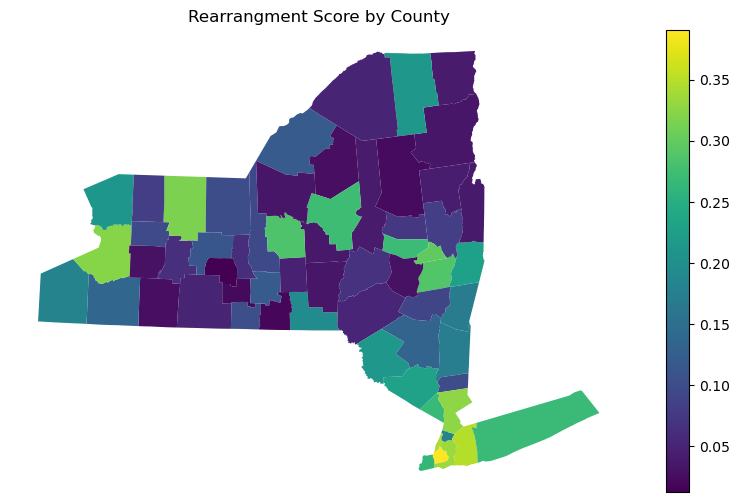

In [22]:
movement_props = data.groupby("COUNTY_NAME").apply(get_movement_prop)

# counties.plot(column="MovementScore", cmap="viridis", legend=True, figsize=(10, 6), edgecolor=None, linewidth=0.5, legend_kwds={"label": "Movement Score", "orientation": "vertical"})
counties.set_index("NAME").assign(MovementScore=movement_props).plot(column="MovementScore", legend=True, figsize=(10, 6), linewidth=0.5)
plt.axis("off")
plt.title("Rearrangment Score by County")
plt.savefig(image_path / "rearrangement_score.png")

In [25]:
agg_white.sort_values("PER_NON_WHITE", ascending=False).head(5)

,NUM_BLACK,NUM_WHITE,NUM_HISP,K12,PER_WHITE,PER_BLACK,PER_HISP,PER_NON_WHITE,movement_props
COUNTY_NAME,,,,,,,,,
BRONX,50734,7901,120578,192634,0.041016,0.263370,0.625943,0.958984,0.179976
QUEENS,40733,28415,100666,250579,0.113397,0.162556,0.401734,0.886603,0.333109
NYC CENTRAL OFFICE,8480,3072,10188,24949,0.123131,0.339893,0.408353,0.876869,0.189510
NEW YORK,33553,24380,66429,149236,0.163365,0.224832,0.445127,0.836635,0.342982
KINGS,95010,47499,83073,282247,0.168289,0.336620,0.294327,0.831711,0.390554


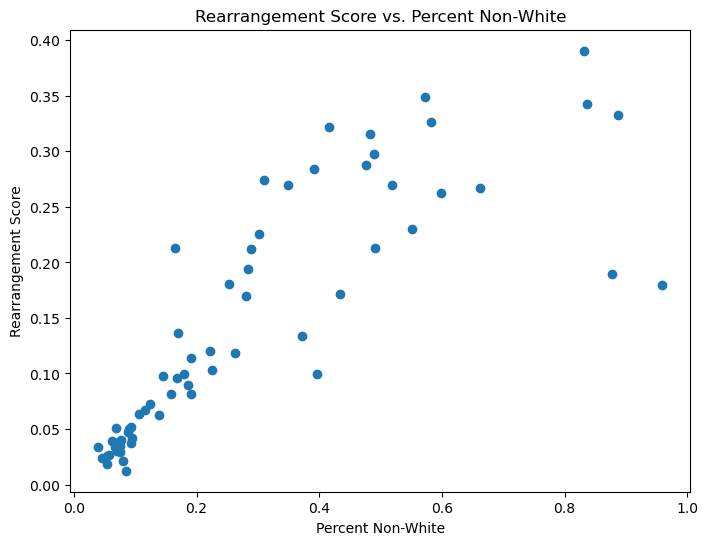

In [24]:
movement_props
agg_white["movement_props"] = movement_props

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(agg_white["PER_NON_WHITE"], agg_white["movement_props"])
ax.set(xlabel="Percent Non-White", ylabel="Rearrangement Score", title="Rearrangement Score vs. Percent Non-White");